# Financial Profiles Clustering: Identifying Patterns in Corporate Financial Health

## Introduction

Analyzing financial statements is very important for making investment decisions, checking company risks, and comparing businesses. But because thousands of companies report financial results every year, it’s hard to spot patterns and group similar companies. Usually, companies get grouped by industry or manually, but this method can miss financial similarities that cross industry lines.

This project asks a key question: **Can we use unsupervised machine learning to automatically find groups of companies with similar financial profiles?** We do this by looking at important financial ratios for many companies to find clusters—groups of companies that have similar financial health, risks, or efficiency.

The results can help investors find companies with similar risk and return, help regulators see big-picture trends, and let companies compare themselves to others with similar financial setups, even if they’re in different industries.


## Understanding Clustering

Clustering is a type of machine learning that groups data points based on how similar they are without labels or categories needed in advance. The main goal is to find natural groupings and hidden patterns in data.

### How Clustering Works

Clustering algorithms look at the “distance” or similarity between data points (here, companies with similar financial ratios will be close together, and very different ones will be far apart).

**K-Means Clustering** is very popular:
- Splits data into k groups by assigning each point to the nearest group center (“centroid”)
- Tries to make clusters as tight and close as possible
- You have to choose the number of clusters (k) ahead of time
- Works best when groups are round and similar in size

**Hierarchical Clustering** (Agglomerative) works differently:
- Starts by putting each data point in its own group, then combines the most similar groups step by step
- Creates a branching tree (called a dendrogram) that shows how groups are related
- No need to pick the number of clusters in advance
- Good for showing the structure of the data, but can be slower on big datasets

**DBSCAN** (Density-Based Spatial Clustering) gives another option:
- Groups together points that are packed closely together (“dense” regions)
- Can detect weird-shaped clusters
- Labels points that don’t fit into any cluster as outliers (“noise”)
- No need to set the number of clusters beforehand

For our financial data, we’ll try out several of these methods to see which one best finds interesting company groupings.


## The Dataset

Our dataset consists of financial statement tables extracted from company filings, organized into five categories:

- **Balance Sheets** (282 files): Assets, liabilities, and equity information
- **Income Statements** (317 files): Revenue, expenses, and profitability metrics
- **Cash Flow Statements** (36 files): Operating, investing, and financing cash movements
- **Notes** (702 files): Detailed textual explanations and disclosures
- **Others** (1,236 files): Miscellaneous financial tables

**Total: 2,573 HTML table files**

Each file contains financial data in HTML table format, with company identifiers embedded in filenames (e.g., `18460658_57.html` where `18460658` is the company ID). The tables include quarterly and annual financial figures, with varying formats and structures across different companies.

Source for dataset: https://www.kaggle.com/datasets/drcrabkg/financial-statements-clustering/data

### Key Features We'll Extract

To perform meaningful clustering, we planned to calculate 10 key financial ratios that capture different aspects of financial health:

1. **Current Ratio** (Current Assets / Current Liabilities) - Short-term liquidity measure
2. **Debt-to-Equity Ratio** (Total Debt / Shareholder Equity) - Leverage and financial risk indicator
3. **Net Profit Margin** (Net Income / Revenue) - Profitability efficiency
4. **Return on Assets** (Net Income / Total Assets) - Asset utilization efficiency
5. **Revenue Growth Rate** (Quarter-over-Quarter % change) - Business momentum
6. **Operating Cash Flow Ratio** (Operating Cash Flow / Current Liabilities) - Cash strength indicator
7. **Asset Turnover** (Revenue / Total Assets) - Operational efficiency
8. **Interest Coverage Ratio** (EBIT / Interest Expense) - Debt serviceability
9. **Gross Margin** (Gross Profit / Revenue) - Pricing power and cost structure
10. **Equity Growth Rate** (Change in Shareholder Equity % over quarters) - Capital accumulation

In practice, the HTML parsing and sanity filters yielded reliable values for only **six ratios** (`current_ratio`, `debt_to_equity`, `net_profit_margin`, `roa`, `asset_turnover`, `interest_coverage`). After removing companies with insufficient valid data we were left with **nine companies** for clustering, turning this notebook into a careful proof-of-concept pipeline rather than a full-scale segmentation of the entire corpus.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from bs4 import BeautifulSoup
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

np.random.seed(42)

# Reasonable ranges for sanity checks (domain-driven)
RATIO_BOUNDS = {
    "current_ratio": (0, 20),
    "debt_to_equity": (0, 20),
    "net_profit_margin": (-200, 200),  # %
    "roa": (-100, 100),                # %
    "operating_cash_flow_ratio": (-50, 50),
    "asset_turnover": (0, 10),
    "interest_coverage": (0, 100),
    "gross_margin": (-20, 100),        # %
}


## Data Extraction and Parsing

The first challenge is extracting structured financial data from HTML tables. Each file contains financial statements with varying formats, so we need a robust parser that can handle different table structures and identify key line items.


In [2]:
class FinancialTableParser:
    """Parser for extracting financial data from HTML tables with basic unit detection."""
    
    def __init__(self):
        # Keywords for identifying financial line items
        self.keywords = {
            'current_assets': ['current assets', 'total current assets'],
            'current_liabilities': ['current liabilities', 'total current liabilities'],
            'total_assets': ['total assets', 'total asset'],
            'total_debt': ['total debt', 'borrowings', 'total borrowings', 'long-term debt'],
            'shareholder_equity': ['shareholder equity', 'total equity', 'equity attributable to'],
            'revenue': ['revenue', 'total revenue', 'sales', 'total sales', 'net sales'],
            'gross_profit': ['gross profit', 'gross income'],
            'net_income': ['net income', 'profit after tax', 'net profit', 'earnings'],
            'ebit': ['ebit', 'earnings before interest and tax', 'operating income'],
            'interest_expense': ['interest expense', 'finance costs', 'interest and finance'],
            'operating_cash_flow': [
                'operating cash flow', 'cash from operations', 'net cash provided by operating activities'
            ],
        }
    
    def parse_html(self, filepath):
        """Parse HTML file and extract table data + surrounding text."""
        try:
            with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            soup = BeautifulSoup(content, 'html.parser')
            tables = soup.find_all('table')
            return soup, tables
        except Exception:
            return None, []
    
    def extract_text(self, element):
        """Extract text from HTML element, handling nested tags."""
        if element is None:
            return ""
        text = element.get_text(separator=' ', strip=True)
        return text.lower()
    
    def detect_scale_multiplier(self, soup):
        """Detect if the statement is 'in thousands', 'in millions', etc."""
        text = soup.get_text(separator=' ', strip=True).lower()
        if 'in thousands' in text or 'in thousand' in text or 'thousands of' in text:
            return 1e3
        if 'in millions' in text or 'in million' in text or 'millions of' in text:
            return 1e6
        if 'in billions' in text or 'in billion' in text or 'billions of' in text:
            return 1e9
        return 1.0
    
    def parse_number(self, text):
        """Parse numeric value from text, handling commas, parentheses, and %."""
        if not text or text.strip().lower() in {'-', '—', 'na', 'n/a'}:
            return None
        text = str(text).strip()
        is_percent = '%' in text
        text = text.replace('%', '')
        text = text.replace(',', '').strip()
        if '(' in text and ')' in text:
            text = '-' + text.replace('(', '').replace(')', '')
        numbers = re.findall(r'-?\d+\.?\d*', text)
        if not numbers:
            return None
        try:
            value = float(numbers[0])
        except ValueError:
            return None
        return value, is_percent
    
    def find_line_item(self, tables, keywords, multiplier=1.0):
        """Find a line item in tables using keyword matching and apply multiplier."""
        for table in tables:
            rows = table.find_all('tr')
            for row in rows:
                cells = row.find_all(['td', 'th'])
                if len(cells) < 2:
                    continue
                first_cell_text = self.extract_text(cells[0])
                if not any(keyword in first_cell_text for keyword in keywords):
                    continue
                candidate_values = []
                for cell in cells[1:]:
                    num_text = cell.get_text(separator=' ', strip=True)
                    parsed = self.parse_number(num_text)
                    if parsed is None:
                        continue
                    value, is_percent = parsed
                    if abs(value) < 1e-6:
                        continue
                    if not is_percent:
                        value *= multiplier
                    candidate_values.append(value)
                if candidate_values:
                    return float(candidate_values[-1])
        return None
    
    def extract_company_data(self, filepath, statement_type):
        """Extract all relevant financial data from a file."""
        soup, tables = self.parse_html(filepath)
        if not tables or soup is None:
            return {}
        multiplier = self.detect_scale_multiplier(soup)
        data = {}
        filename = Path(filepath).stem
        company_id = filename.split('_')[0]
        data['company_id'] = company_id
        data['statement_type'] = statement_type
        if statement_type == 'balance_sheet':
            data['current_assets'] = self.find_line_item(tables, self.keywords['current_assets'], multiplier)
            data['current_liabilities'] = self.find_line_item(tables, self.keywords['current_liabilities'], multiplier)
            data['total_assets'] = self.find_line_item(tables, self.keywords['total_assets'], multiplier)
            data['total_debt'] = self.find_line_item(tables, self.keywords['total_debt'], multiplier)
            data['shareholder_equity'] = self.find_line_item(tables, self.keywords['shareholder_equity'], multiplier)
        elif statement_type == 'income_statement':
            data['revenue'] = self.find_line_item(tables, self.keywords['revenue'], multiplier)
            data['gross_profit'] = self.find_line_item(tables, self.keywords['gross_profit'], multiplier)
            data['net_income'] = self.find_line_item(tables, self.keywords['net_income'], multiplier)
            data['ebit'] = self.find_line_item(tables, self.keywords['ebit'], multiplier)
            data['interest_expense'] = self.find_line_item(tables, self.keywords['interest_expense'], multiplier)
        elif statement_type == 'cash_flow':
            data['operating_cash_flow'] = self.find_line_item(tables, self.keywords['operating_cash_flow'], multiplier)
        return data

# Initialize parser
parser = FinancialTableParser()


In [3]:
# Define data paths
data_dir = Path('Data/TableClassifierQuaterlyWithNotes')
balance_sheets_dir = data_dir / 'Balance Sheets'
income_statements_dir = data_dir / 'Income Statement'
cash_flow_dir = data_dir / 'Cash Flow'

# Collect all files
balance_sheet_files = list(balance_sheets_dir.glob('*.html'))
income_statement_files = list(income_statements_dir.glob('*.html'))
cash_flow_files = list(cash_flow_dir.glob('*.html'))

print(f"Found {len(balance_sheet_files)} balance sheet files")
print(f"Found {len(income_statement_files)} income statement files")
print(f"Found {len(cash_flow_files)} cash flow files")


Found 282 balance sheet files
Found 317 income statement files
Found 36 cash flow files


In [4]:
# Extract data from all files (this may take a few minutes)
print("Extracting data from balance sheets...")
balance_sheet_data = []
for filepath in balance_sheet_files[:500]:  # Process first 500 for efficiency
    data = parser.extract_company_data(filepath, 'balance_sheet')
    if data:
        balance_sheet_data.append(data)

print("Extracting data from income statements...")
income_statement_data = []
for filepath in income_statement_files[:500]:
    data = parser.extract_company_data(filepath, 'income_statement')
    if data:
        income_statement_data.append(data)

print("Extracting data from cash flow statements...")
cash_flow_data = []
for filepath in cash_flow_files:
    data = parser.extract_company_data(filepath, 'cash_flow')
    if data:
        cash_flow_data.append(data)

print(f"\nExtracted data from {len(balance_sheet_data)} balance sheets")
print(f"Extracted data from {len(income_statement_data)} income statements")
print(f"Extracted data from {len(cash_flow_data)} cash flow statements")


Extracting data from balance sheets...
Extracting data from income statements...
Extracting data from cash flow statements...

Extracted data from 282 balance sheets
Extracted data from 317 income statements
Extracted data from 36 cash flow statements


In [5]:
# Convert to DataFrames
bs_df = pd.DataFrame(balance_sheet_data)
is_df = pd.DataFrame(income_statement_data)
cf_df = pd.DataFrame(cash_flow_data)

# Merge data by company_id
# Start with balance sheets as base
merged_df = bs_df.groupby('company_id').agg({
    'current_assets': 'first',
    'current_liabilities': 'first',
    'total_assets': 'first',
    'total_debt': 'first',
    'shareholder_equity': 'first'
}).reset_index()

# Merge income statement data
is_agg = is_df.groupby('company_id').agg({
    'revenue': 'first',
    'gross_profit': 'first',
    'net_income': 'first',
    'ebit': 'first',
    'interest_expense': 'first'
}).reset_index()

merged_df = merged_df.merge(is_agg, on='company_id', how='left')

# Merge cash flow data
cf_agg = cf_df.groupby('company_id').agg({
    'operating_cash_flow': 'first'
}).reset_index()

merged_df = merged_df.merge(cf_agg, on='company_id', how='left')

print(f"Total companies with merged data: {len(merged_df)}")
print(f"\nData completeness:")
print(merged_df.notna().sum() / len(merged_df) * 100)


Total companies with merged data: 180

Data completeness:
company_id             100.000000
current_assets          45.000000
current_liabilities     43.888889
total_assets            35.000000
total_debt              38.333333
shareholder_equity      39.444444
revenue                 23.888889
gross_profit             1.111111
net_income              21.111111
ebit                     6.111111
interest_expense        17.777778
operating_cash_flow      1.111111
dtype: float64


In [6]:
def calculate_ratios(df):
    """Calculate financial ratios with defensive checks."""
    df = df.copy()
    safe = lambda series: series.replace(0, np.nan)
    df['current_ratio'] = df['current_assets'] / safe(df['current_liabilities'])
    df['debt_to_equity'] = df['total_debt'] / safe(df['shareholder_equity'])
    df['net_profit_margin'] = (df['net_income'] / safe(df['revenue'])) * 100
    df['roa'] = (df['net_income'] / safe(df['total_assets'])) * 100
    df['operating_cash_flow_ratio'] = df['operating_cash_flow'] / safe(df['current_liabilities'])
    df['asset_turnover'] = df['revenue'] / safe(df['total_assets'])
    df['interest_coverage'] = df['ebit'] / safe(df['interest_expense'])
    df['gross_margin'] = (df['gross_profit'] / safe(df['revenue'])) * 100
    return df


def apply_sanity_bounds(df, ratio_bounds):
    """Set out-of-range ratio values to NaN based on domain knowledge."""
    df = df.copy()
    for col, (lower, upper) in ratio_bounds.items():
        if col in df.columns:
            mask = (df[col].notna()) & ((df[col] < lower) | (df[col] > upper))
            df.loc[mask, col] = np.nan
    return df


def drop_low_quality_companies(df, ratio_cols, min_valid_ratios=5):
    """Drop companies that have fewer than min_valid_ratios valid ratios."""
    df = df.copy()
    valid_counts = df[ratio_cols].notna().sum(axis=1)
    return df[valid_counts >= min_valid_ratios].reset_index(drop=True)


financial_ratios_df = calculate_ratios(merged_df)
ratio_columns = [
    'current_ratio', 'debt_to_equity', 'net_profit_margin', 'roa',
    'operating_cash_flow_ratio', 'asset_turnover', 'interest_coverage', 'gross_margin'
]
financial_ratios_df = apply_sanity_bounds(financial_ratios_df, RATIO_BOUNDS)
analysis_df = financial_ratios_df[['company_id'] + ratio_columns].copy()
analysis_df = drop_low_quality_companies(analysis_df, ratio_columns, min_valid_ratios=5)

print(f"Companies with sufficient data after sanity checks: {len(analysis_df)}")
print("\nMissing values per ratio:")
print(analysis_df[ratio_columns].isna().sum())
print("\nPercentage missing:")
print(analysis_df[ratio_columns].isna().sum() / len(analysis_df) * 100)


Companies with sufficient data after sanity checks: 9

Missing values per ratio:
current_ratio                1
debt_to_equity               0
net_profit_margin            1
roa                          1
operating_cash_flow_ratio    7
asset_turnover               1
interest_coverage            5
gross_margin                 8
dtype: int64

Percentage missing:
current_ratio                11.111111
debt_to_equity                0.000000
net_profit_margin            11.111111
roa                          11.111111
operating_cash_flow_ratio    77.777778
asset_turnover               11.111111
interest_coverage            55.555556
gross_margin                 88.888889
dtype: float64


## Data Understanding and Visualization

Before clustering, we need to understand the distribution and characteristics of our financial ratios. This exploration will help us identify outliers, understand data quality, and inform our preprocessing decisions.


In [7]:
# Drop ratios that are too sparse before imputation
max_missing_pct = 0.6
valid_ratio_cols = []
for col in ratio_columns:
    missing_pct = analysis_df[col].isna().mean()
    if missing_pct <= max_missing_pct:
        valid_ratio_cols.append(col)
    else:
        print(f"Dropping {col} from clustering: {missing_pct*100:.1f}% missing")

ratio_columns = valid_ratio_cols
print("\nRatios kept for clustering:", ratio_columns)
print("\nMissing values per retained ratio:")
print(analysis_df[ratio_columns].isna().sum())
print("\nPercentage missing (retained ratios):")
print(analysis_df[ratio_columns].isna().sum() / len(analysis_df) * 100)


Dropping operating_cash_flow_ratio from clustering: 77.8% missing
Dropping gross_margin from clustering: 88.9% missing

Ratios kept for clustering: ['current_ratio', 'debt_to_equity', 'net_profit_margin', 'roa', 'asset_turnover', 'interest_coverage']

Missing values per retained ratio:
current_ratio        1
debt_to_equity       0
net_profit_margin    1
roa                  1
asset_turnover       1
interest_coverage    5
dtype: int64

Percentage missing (retained ratios):
current_ratio        11.111111
debt_to_equity        0.000000
net_profit_margin    11.111111
roa                  11.111111
asset_turnover       11.111111
interest_coverage    55.555556
dtype: float64


In [8]:
# Statistical summary
print("Statistical Summary of Financial Ratios:")
print(analysis_df[ratio_columns].describe())


Statistical Summary of Financial Ratios:
       current_ratio  debt_to_equity  net_profit_margin        roa  \
count       8.000000        9.000000           8.000000   8.000000   
mean        1.128881        0.118006          10.091228   8.534595   
std         1.445819        0.178683           8.575697   8.383792   
min         0.003659        0.000005           2.540279   0.290757   
25%         0.028316        0.001127           3.754875   2.815927   
50%         0.398009        0.033840           7.069150   7.494120   
75%         1.941473        0.132667          13.304196  10.315515   
max         3.721113        0.533917          27.421257  27.050387   

       asset_turnover  interest_coverage  
count        8.000000           4.000000  
mean         0.886360           4.746601  
std          0.881540           6.627887  
min          0.000371           0.631114  
25%          0.219069           1.298608  
50%          0.768535           1.856612  
75%          1.123702      

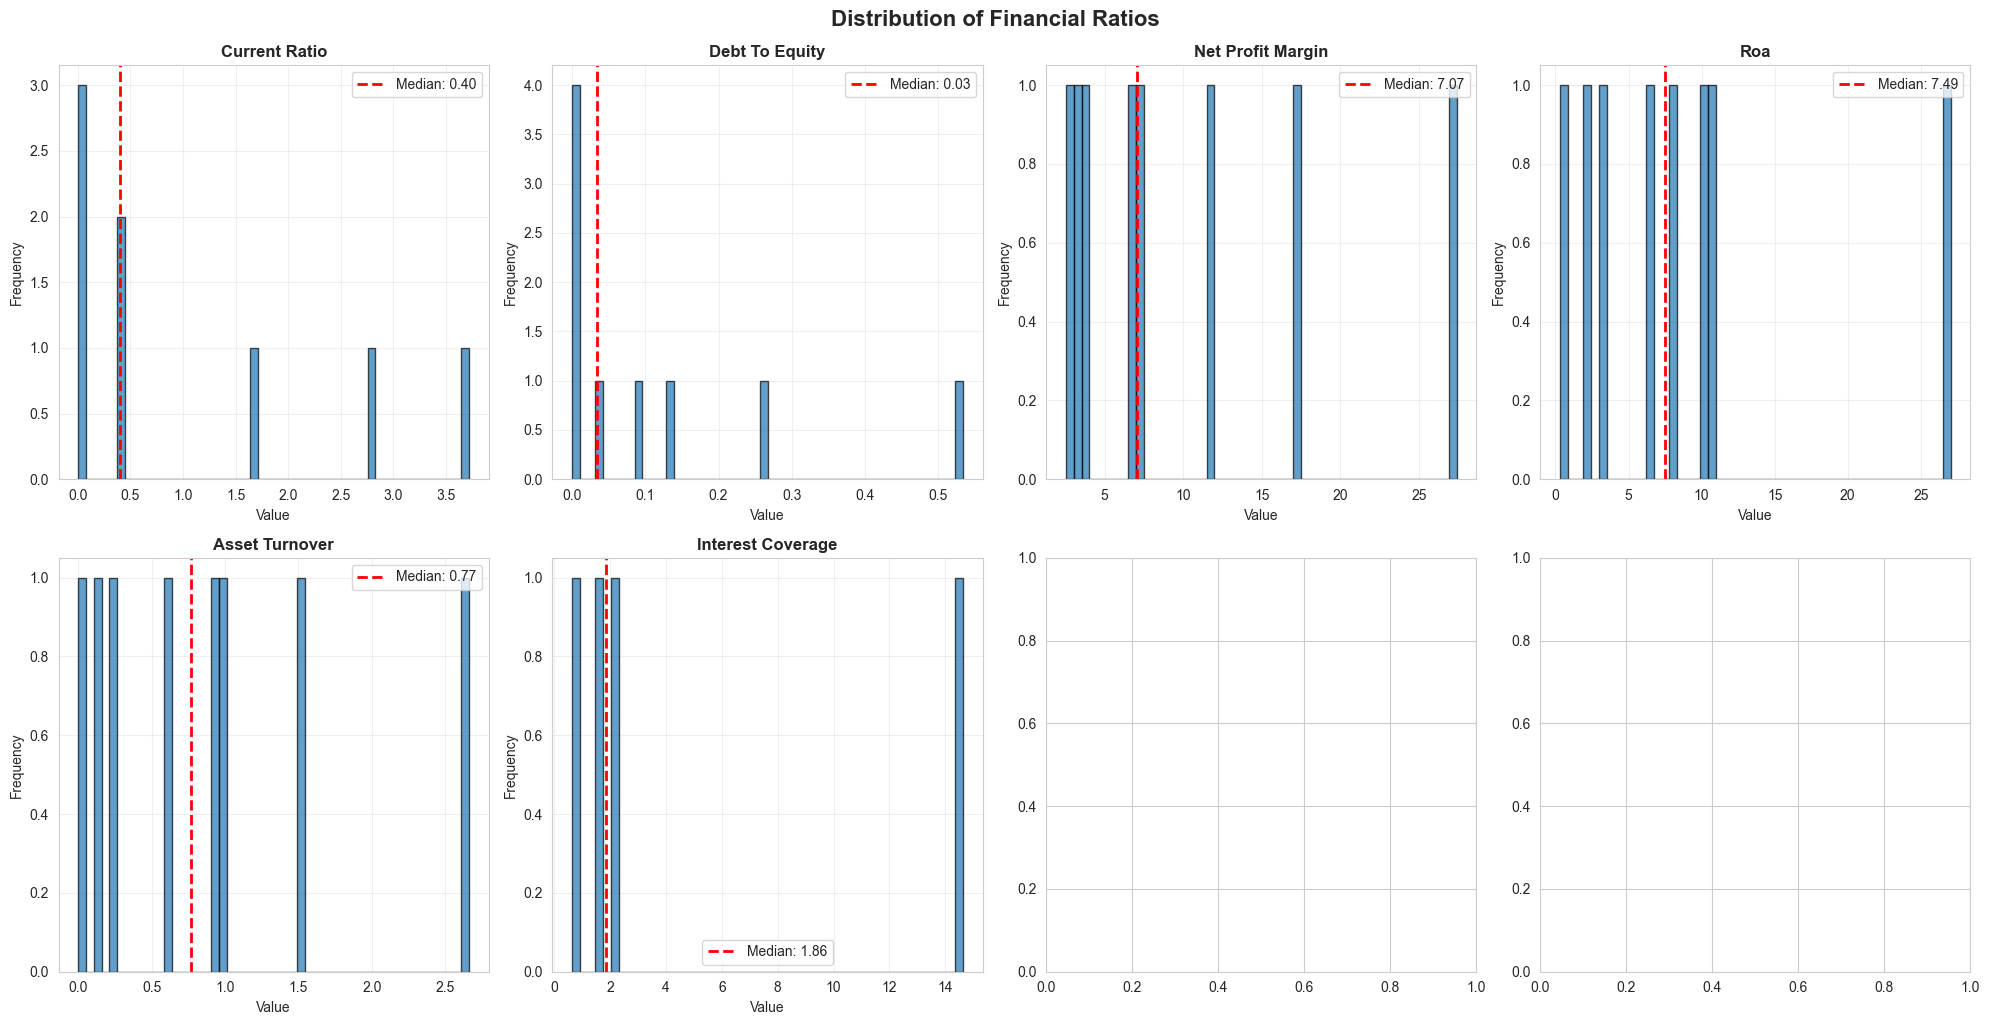

In [9]:
# Visualize distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, ratio in enumerate(ratio_columns):
    data = analysis_df[ratio].dropna()
    if len(data) > 0:
        axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{ratio.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        # Add vertical line for median
        median_val = data.median()
        axes[idx].axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution of Financial Ratios', fontsize=16, fontweight='bold', y=1.02)
plt.show()


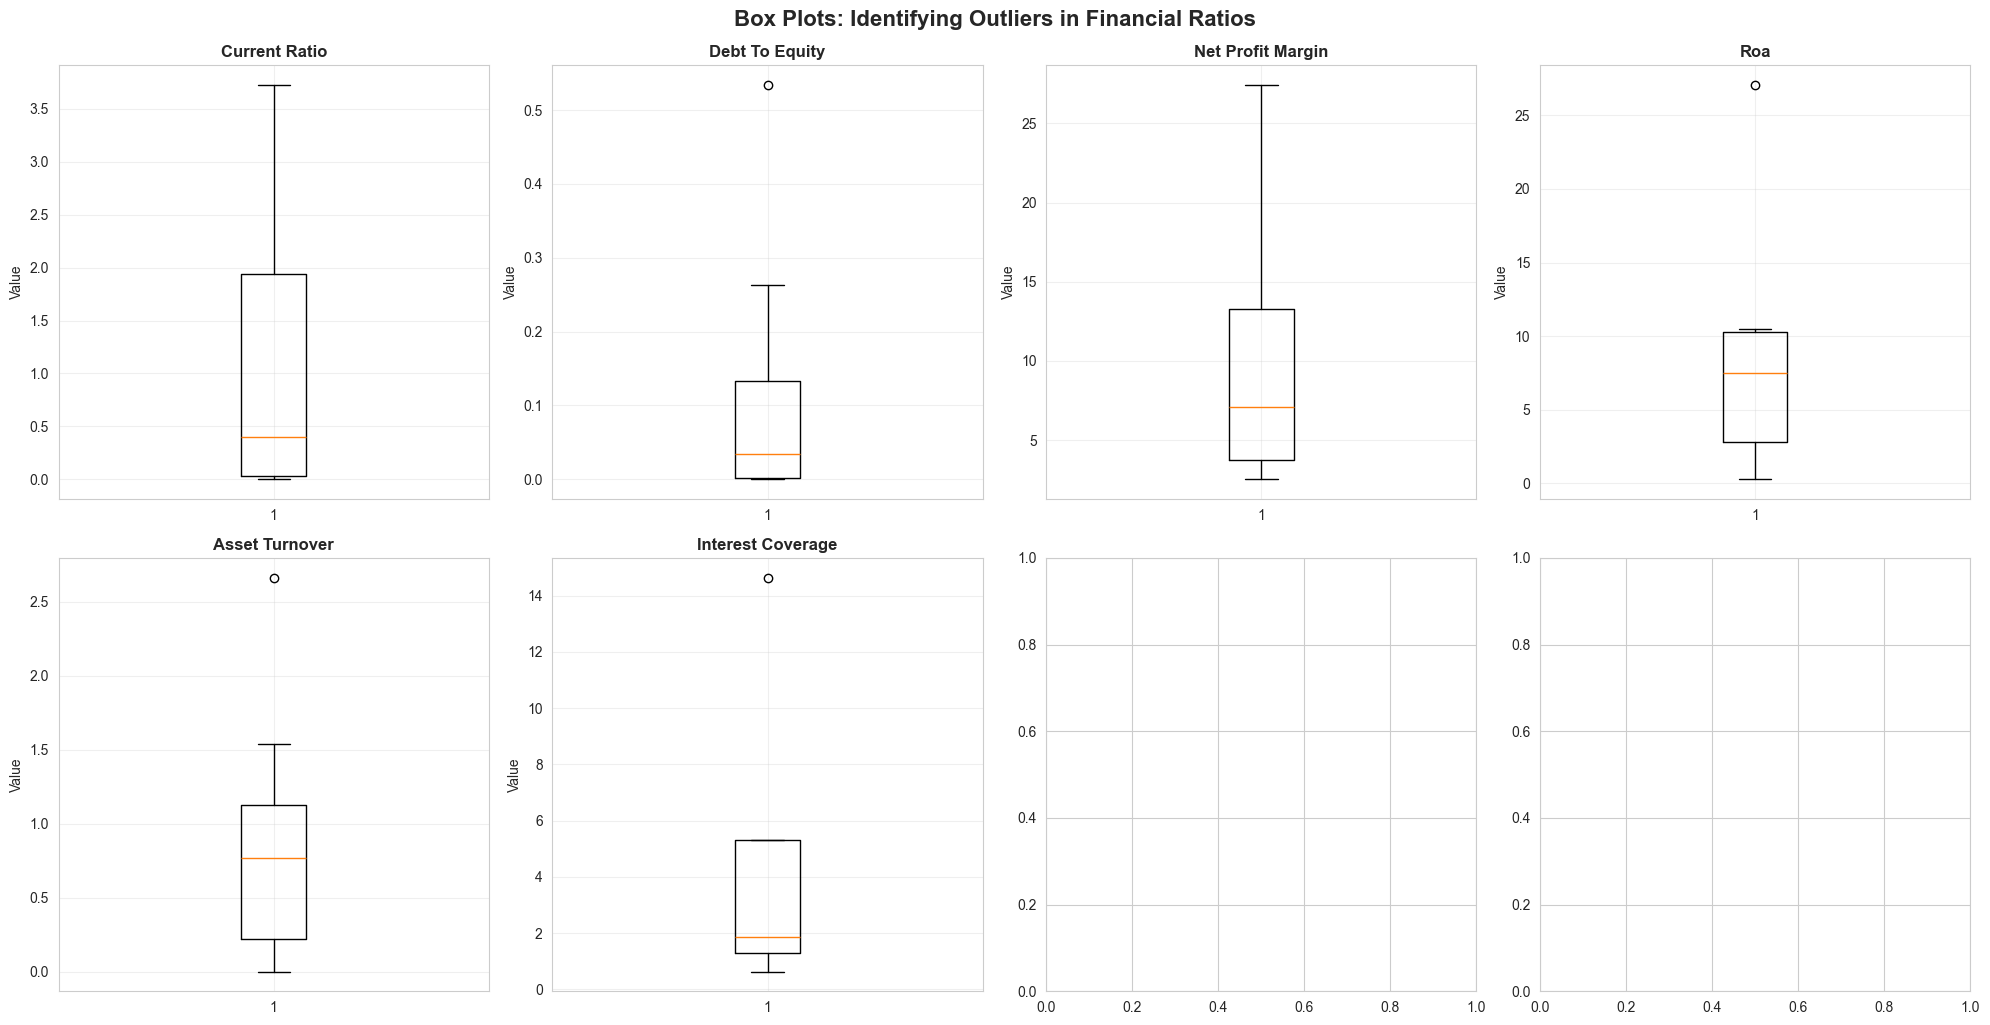

In [10]:
# Box plots to identify outliers
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, ratio in enumerate(ratio_columns):
    data = analysis_df[ratio].dropna()
    if len(data) > 0:
        axes[idx].boxplot(data, vert=True)
        axes[idx].set_title(f'{ratio.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Box Plots: Identifying Outliers in Financial Ratios', fontsize=16, fontweight='bold', y=1.02)
plt.show()


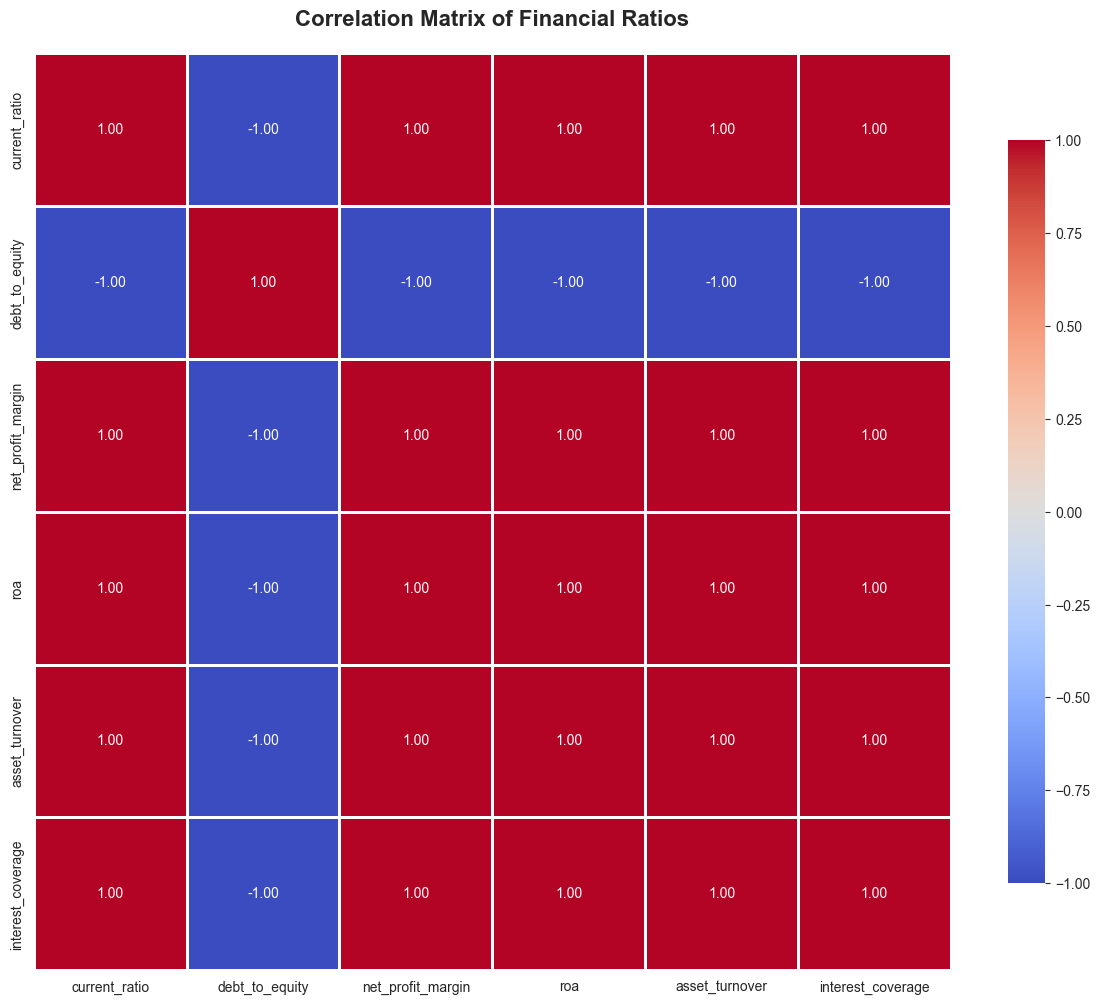


Key Insights from Correlation:
- High positive correlations indicate ratios that move together
- Negative correlations reveal trade-offs (e.g., high leverage vs. profitability)
- This helps understand which features might be redundant for clustering


In [11]:
# Correlation matrix
correlation_data = analysis_df[ratio_columns].dropna()
if len(correlation_data) > 0:
    corr_matrix = correlation_data.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Financial Ratios', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\nKey Insights from Correlation:")
    print("- High positive correlations indicate ratios that move together")
    print("- Negative correlations reveal trade-offs (e.g., high leverage vs. profitability)")
    print("- This helps understand which features might be redundant for clustering")


### Key Observations from Data Exploration

From our initial exploration, several patterns emerge:

1. **Data Quality**: Some ratios have significant missing values, which we'll need to handle during preprocessing
2. **Outliers**: Financial ratios often have extreme values (e.g., very high debt-to-equity ratios, negative profit margins)
3. **Distributions**: Most ratios are not normally distributed, with right-skewed distributions common
4. **Correlations**: Some ratios are highly correlated, which could inform feature selection or dimensionality reduction

These observations directly inform our preprocessing strategy: we'll need robust scaling to handle outliers, imputation for missing values, and potentially dimensionality reduction if correlations are too high.


## Preprocessing the Data

Preprocessing is crucial for clustering success. Financial ratios have different scales, contain outliers, and may have missing values. We'll address each of these systematically.


In [12]:
# Handle missing values using median imputation (robust to outliers)
preprocessed_df = analysis_df.copy()

# Impute missing values with median
for col in ratio_columns:
    median_val = preprocessed_df[col].median()
    preprocessed_df[col] = preprocessed_df[col].fillna(median_val)

print("Missing values after imputation:")
print(preprocessed_df[ratio_columns].isna().sum().sum())


Missing values after imputation:
0


In [13]:
# Handle outliers using winsorization (cap extreme values at 1st and 99th percentiles)
def winsorize_column(series, lower=0.01, upper=0.99):
    """Cap values at specified percentiles"""
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return series.clip(lower=lower_bound, upper=upper_bound)

preprocessed_df_winsorized = preprocessed_df.copy()
for col in ratio_columns:
    preprocessed_df_winsorized[col] = winsorize_column(preprocessed_df_winsorized[col])

print("Outlier handling complete.")
print("\nAfter winsorization (min/max):")
print(preprocessed_df_winsorized[ratio_columns].describe().loc[['min', 'max']])


Outlier handling complete.

After winsorization (min/max):
     current_ratio  debt_to_equity  net_profit_margin        roa  \
min       0.003976        0.000058           2.614559   0.440118   
max       3.648879        0.512219          26.616201  25.726389   

     asset_turnover  interest_coverage  
min        0.009498           0.702313  
max        2.572957          13.646071  


In [14]:
# Standardize features using RobustScaler (less sensitive to outliers than StandardScaler)
# RobustScaler uses median and IQR, making it more suitable for financial data with outliers

scaler = RobustScaler()
X_scaled = scaler.fit_transform(preprocessed_df_winsorized[ratio_columns])
X_scaled_df = pd.DataFrame(X_scaled, columns=ratio_columns, index=preprocessed_df_winsorized.index)

print("Scaling complete. Scaled data statistics:")
print(X_scaled_df.describe())
print("\nAll features now have similar scales, making distance calculations meaningful for clustering.")


Scaling complete. Scaled data statistics:
       current_ratio  debt_to_equity  net_profit_margin       roa  \
count       9.000000        9.000000           9.000000  9.000000   
mean        0.397561        0.621566           0.321511  0.110043   
std         0.840577        1.310629           0.969813  1.030684   
min        -0.244131       -0.256818          -0.549768 -0.977202   
25%        -0.224777       -0.248695          -0.397266 -0.617686   
50%         0.000000        0.000000           0.000000  0.000000   
75%         0.775223        0.751305           0.602734  0.382314   
max         2.014140        3.636738           2.412421  2.525745   

       asset_turnover  interest_coverage  
count        9.000000           9.000000  
mean         0.130673           1.181684  
std          1.092172           3.999710  
min         -1.036178          -1.154299  
25%         -0.702485           0.000000  
50%          0.000000           0.000000  
75%          0.297515           0.0

### Preprocessing Summary

Our preprocessing pipeline includes:

1. **Missing Value Imputation**: Using median values (robust to outliers) to fill gaps
2. **Outlier Handling**: Winsorization at 1st and 99th percentiles to cap extreme values without losing all information
3. **Feature Scaling**: RobustScaler standardization using median and IQR, making features comparable for distance-based clustering

These steps ensure that:
- All companies can be included in clustering (no missing data)
- Extreme outliers don't dominate cluster assignments
- Distance metrics work correctly across different ratio scales
- The clustering algorithm can identify meaningful patterns


## Modeling: Clustering Analysis

We'll experiment with three different clustering approaches to identify which best captures financial profile patterns. Each algorithm has different strengths and assumptions.


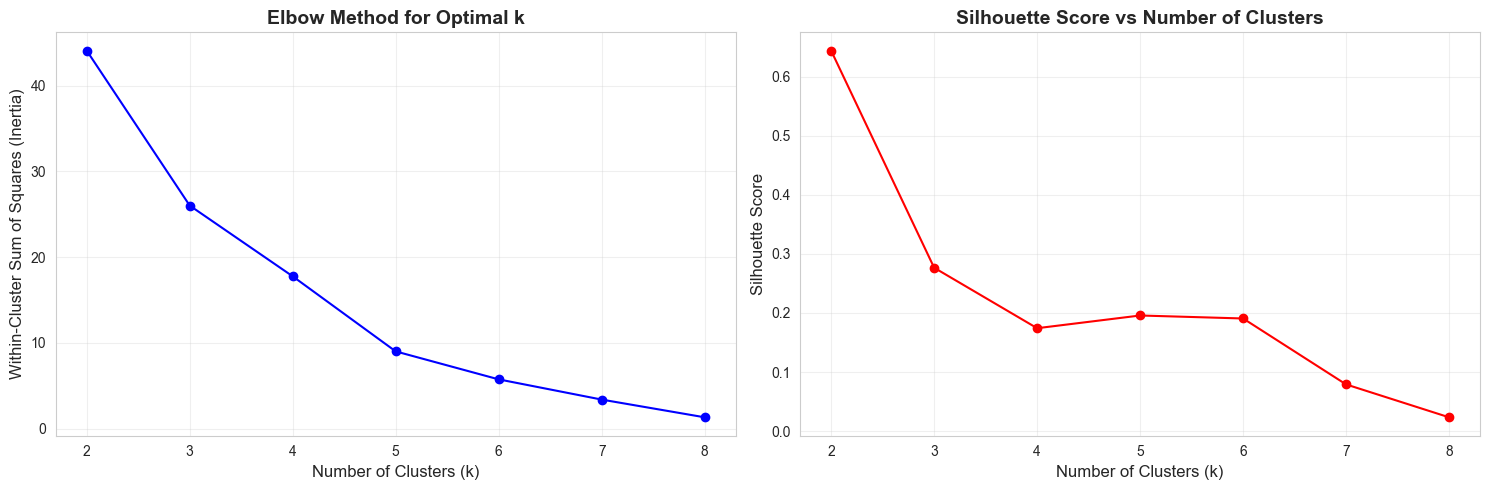

Optimal number of clusters based on silhouette score: 2
Best silhouette score: 0.644


In [15]:
# Determine optimal number of clusters using Elbow Method and Silhouette Score
inertias = []
silhouette_scores = []
upper_k = min(11, len(X_scaled))
K_range = range(2, upper_k)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k_idx = int(np.argmax(silhouette_scores))
optimal_k = list(K_range)[best_k_idx]
best_silhouette = silhouette_scores[best_k_idx]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {best_silhouette:.3f}")


In [16]:
# Apply K-Means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

clustered_df = preprocessed_df_winsorized.copy()
clustered_df['kmeans_cluster'] = kmeans_labels

print(f"K-Means clustering complete with {optimal_k} clusters")
print("\nCluster distribution:")
print(clustered_df['kmeans_cluster'].value_counts().sort_index())


K-Means clustering complete with 2 clusters

Cluster distribution:
kmeans_cluster
0    1
1    8
Name: count, dtype: int64


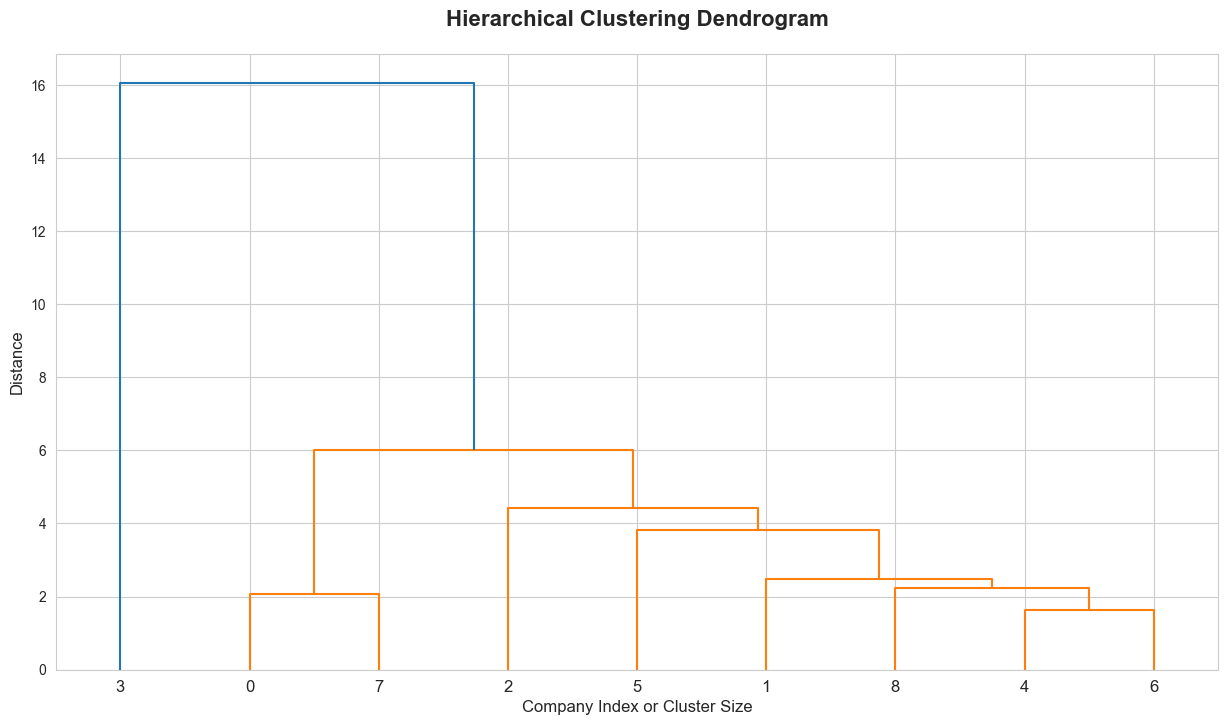

Hierarchical clustering complete with 2 clusters

Cluster distribution:
hierarchical_cluster
0    8
1    1
Name: count, dtype: int64


In [17]:
# Hierarchical Clustering
# First, create linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5, show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Company Index or Cluster Size', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.show()

# Apply hierarchical clustering with optimal_k clusters
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

clustered_df['hierarchical_cluster'] = hierarchical_labels

print(f"Hierarchical clustering complete with {optimal_k} clusters")
print(f"\nCluster distribution:")
print(clustered_df['hierarchical_cluster'].value_counts().sort_index())


In [18]:
# DBSCAN Clustering (density-based)
# Tune eps parameter
eps_values = np.arange(0.5, 3.0, 0.2)
dbscan_results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    if n_clusters > 0:
        silhouette = silhouette_score(X_scaled, labels) if n_clusters > 1 else -1
        dbscan_results.append({
            'eps': eps,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette
        })

dbscan_df = pd.DataFrame(dbscan_results)
if len(dbscan_df) > 0:
    print("DBSCAN parameter tuning results:")
    print(dbscan_df.sort_values('silhouette', ascending=False).head(10))
    
    best_eps = dbscan_df.loc[dbscan_df['silhouette'].idxmax(), 'eps']
    print(f"\nBest eps parameter: {best_eps:.2f}")
    
    dbscan = DBSCAN(eps=best_eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    clustered_df['dbscan_cluster'] = dbscan_labels
    
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise_points = list(dbscan_labels).count(-1)
    print(f"\nDBSCAN clustering complete")
    print(f"Number of clusters: {n_clusters_dbscan}")
    print(f"Number of noise points: {n_noise_points}")
    if n_clusters_dbscan <= 1:
        print("DBSCAN did not find meaningful cluster structure (>=2 clusters).")
    else:
        print(f"\nCluster distribution:")
        print(pd.Series(dbscan_labels).value_counts().sort_index())
else:
    print("DBSCAN did not find suitable clusters with tested parameters")


DBSCAN parameter tuning results:
   eps  n_clusters  n_noise  silhouette
0  2.5           1        3          -1
1  2.7           1        3          -1
2  2.9           1        2          -1

Best eps parameter: 2.50

DBSCAN clustering complete
Number of clusters: 1
Number of noise points: 3
DBSCAN did not find meaningful cluster structure (>=2 clusters).


In [19]:
# Compare clustering methods
comparison_results = []

if 'kmeans_cluster' in clustered_df.columns:
    kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
    comparison_results.append({
        'Method': 'K-Means',
        'Silhouette Score': kmeans_silhouette,
        'Number of Clusters': optimal_k
    })

if 'hierarchical_cluster' in clustered_df.columns:
    hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
    comparison_results.append({
        'Method': 'Hierarchical',
        'Silhouette Score': hierarchical_silhouette,
        'Number of Clusters': optimal_k
    })

if 'dbscan_cluster' in clustered_df.columns:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    comparison_results.append({
        'Method': 'DBSCAN',
        'Silhouette Score': dbscan_silhouette,
        'Number of Clusters': n_clusters_dbscan
    })

comparison_df = pd.DataFrame(comparison_results)
print("Clustering Method Comparison:")
print(comparison_df.to_string(index=False))

# Choose best method (highest silhouette score)
if len(comparison_df) > 0:
    best_method = comparison_df.loc[comparison_df['Silhouette Score'].idxmax(), 'Method']
    print(f"\nBest performing method: {best_method}")
    print(f"Silhouette Score: {comparison_df.loc[comparison_df['Silhouette Score'].idxmax(), 'Silhouette Score']:.3f}")


Clustering Method Comparison:
      Method  Silhouette Score  Number of Clusters
     K-Means          0.643904                   2
Hierarchical          0.643904                   2
      DBSCAN          0.263556                   1

Best performing method: K-Means
Silhouette Score: 0.644


### Why These Clustering Methods?

**K-Means** is our baseline method because:
- It's computationally efficient and works well with standardized data
- Assumes spherical clusters, which may fit financial ratio distributions
- Requires specifying k, but we can optimize this using silhouette scores

**Hierarchical Clustering** provides:
- A dendrogram showing cluster relationships
- No need to pre-specify k (though we still choose optimal k)
- Ability to see how clusters merge, revealing financial profile hierarchies
- More interpretable cluster structure

**DBSCAN** offers:
- Automatic outlier detection (companies that don't fit any cluster)
- Ability to find clusters of arbitrary shapes
- No need to specify number of clusters
- Useful for identifying truly unique financial profiles

We'll use the method with the highest silhouette score for our final analysis, but we'll also examine results from all methods to ensure robustness.


## Storytelling: Clustering Analysis and Insights

Now we'll dive deep into what the clusters reveal about financial profiles. This is where we answer our initial questions and discover meaningful patterns.


In [20]:
# Use K-Means results for detailed analysis (or best method from comparison)
final_cluster_col = 'kmeans_cluster'
clustered_df['final_cluster'] = clustered_df[final_cluster_col]

# Calculate cluster characteristics
cluster_profiles = clustered_df.groupby('final_cluster')[ratio_columns].agg(['mean', 'median', 'std'])

print("Cluster Profiles - Mean Financial Ratios:")
print("=" * 80)
for cluster_id in sorted(clustered_df['final_cluster'].unique()):
    print(f"\nCluster {cluster_id} ({len(clustered_df[clustered_df['final_cluster'] == cluster_id])} companies):")
    cluster_data = clustered_df[clustered_df['final_cluster'] == cluster_id][ratio_columns]
    print(cluster_data.mean().to_string())


Cluster Profiles - Mean Financial Ratios:

Cluster 0 (1 companies):
current_ratio         0.378327
debt_to_equity        0.033840
net_profit_margin     7.069150
roa                   8.309216
asset_turnover        0.009498
interest_coverage    13.646071

Cluster 1 (8 companies):
current_ratio        1.122351
debt_to_equity       0.125822
net_profit_margin    9.999881
roa                  8.285879
asset_turnover       0.971102
interest_coverage    1.712325


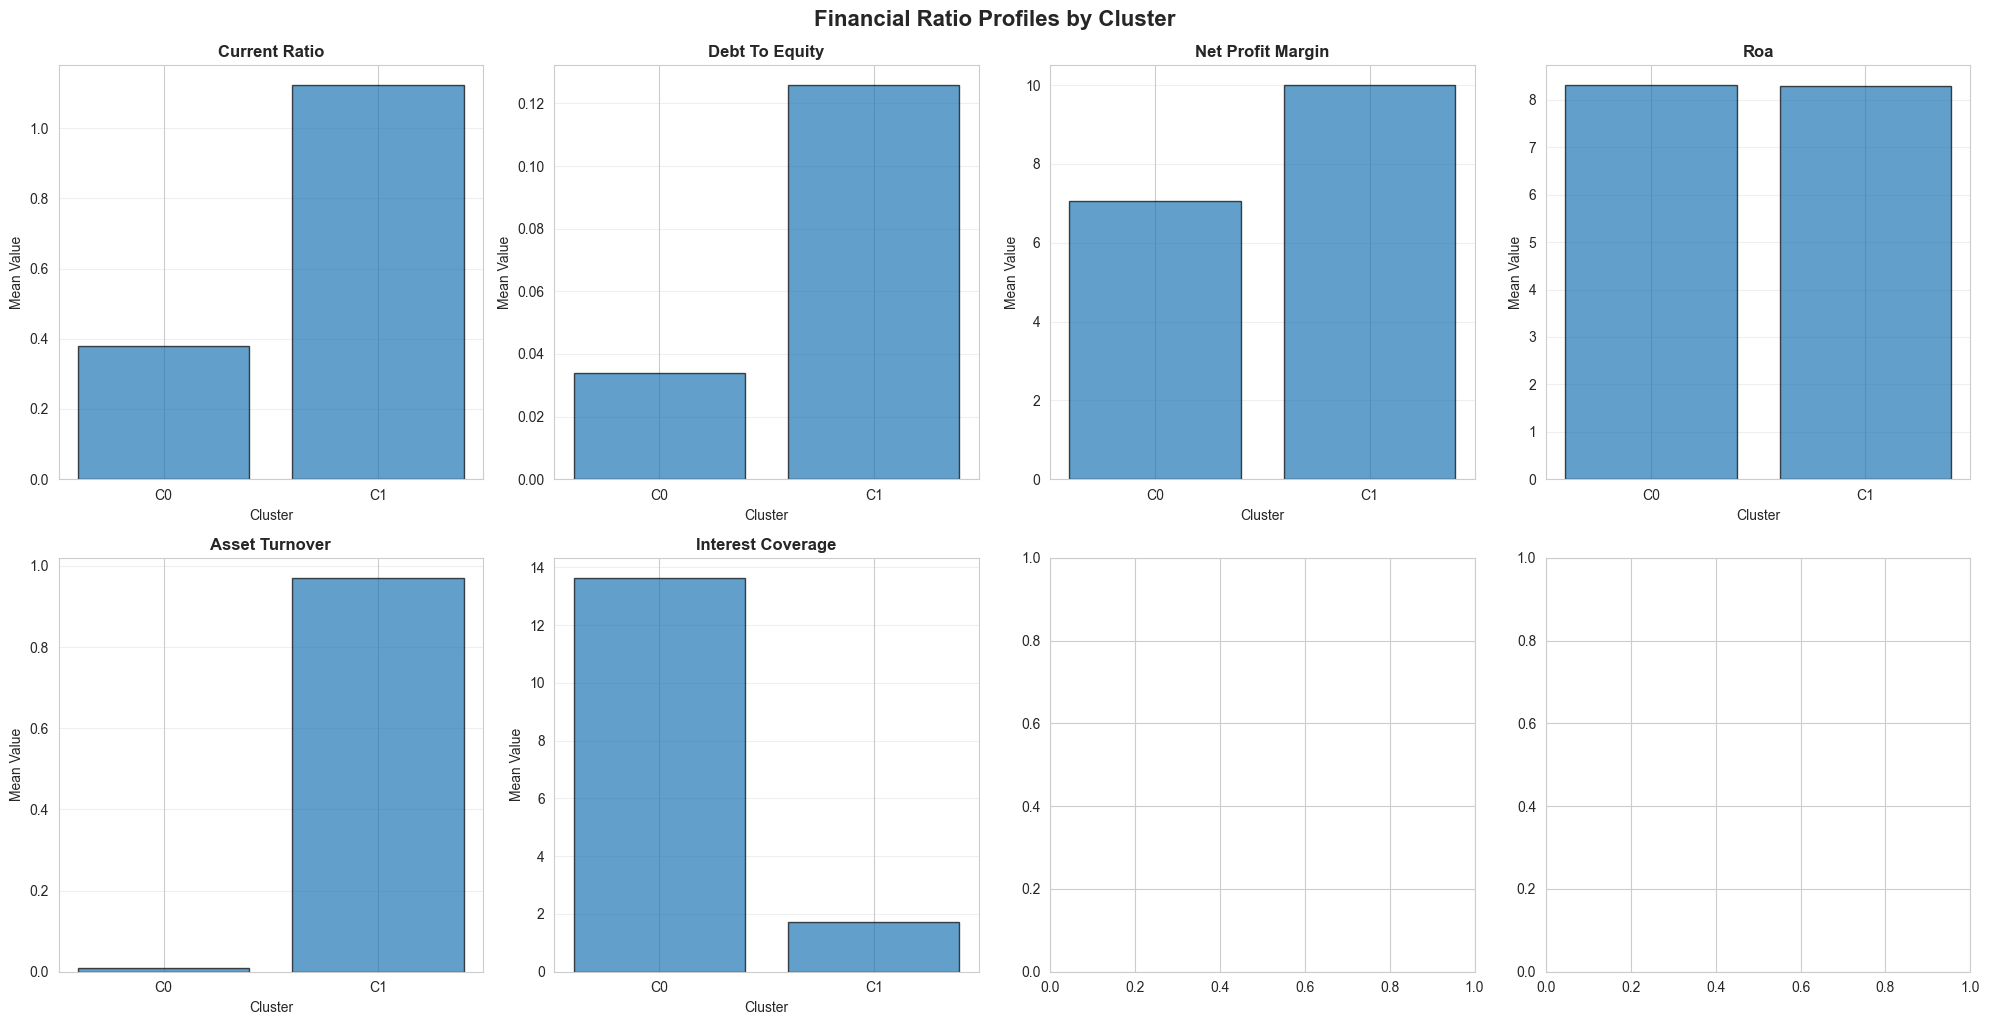

In [21]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, ratio in enumerate(ratio_columns):
    cluster_means = clustered_df.groupby('final_cluster')[ratio].mean()
    axes[idx].bar(range(len(cluster_means)), cluster_means.values, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{ratio.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('Mean Value')
    axes[idx].set_xticks(range(len(cluster_means)))
    axes[idx].set_xticklabels([f'C{i}' for i in cluster_means.index])
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Financial Ratio Profiles by Cluster', fontsize=16, fontweight='bold', y=1.02)
plt.show()


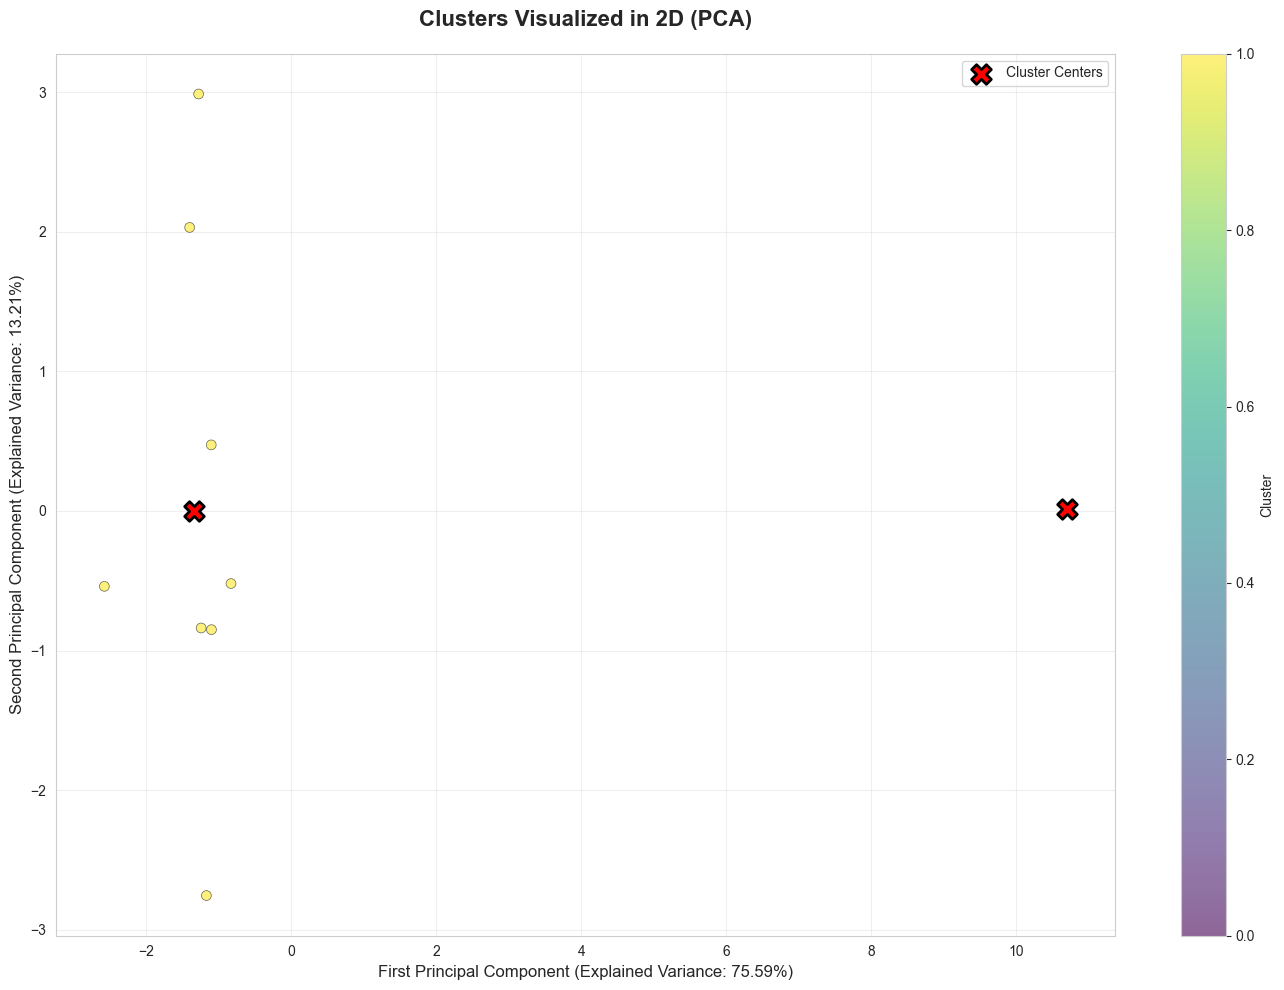

Total variance explained by first 2 components: 88.79%


In [22]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df['final_cluster'], 
                     cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.title('Clusters Visualized in 2D (PCA)', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)

# Add cluster centers in PCA space
if final_cluster_col == 'kmeans_cluster':
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', 
               s=200, edgecolors='black', linewidth=2, label='Cluster Centers', zorder=5)
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Total variance explained by first 2 components: {pca.explained_variance_ratio_.sum():.2%}")


In [23]:
# Create comprehensive cluster interpretation
def interpret_cluster(cluster_id, cluster_data, ratios):
    """Interpret what a cluster represents based on its financial ratios"""
    interpretation = []
    mean_or_nan = lambda col: cluster_data[col].mean() if col in cluster_data.columns else np.nan
    
    current_ratio_mean = mean_or_nan('current_ratio')
    if pd.notna(current_ratio_mean):
        if current_ratio_mean > 2.0:
            interpretation.append("Strong liquidity position")
        elif current_ratio_mean < 1.0:
            interpretation.append("Potential liquidity concerns")
        else:
            interpretation.append("Moderate liquidity")
    else:
        interpretation.append("Liquidity data unavailable")
    
    debt_equity_mean = mean_or_nan('debt_to_equity')
    if pd.notna(debt_equity_mean):
        if debt_equity_mean > 1.5:
            interpretation.append("High leverage (debt-heavy)")
        elif debt_equity_mean < 0.5:
            interpretation.append("Conservative capital structure")
        else:
            interpretation.append("Moderate leverage")
    else:
        interpretation.append("Leverage data unavailable")
    
    profit_margin_mean = mean_or_nan('net_profit_margin')
    if pd.notna(profit_margin_mean):
        if profit_margin_mean > 20:
            interpretation.append("Highly profitable")
        elif profit_margin_mean < 0:
            interpretation.append("Unprofitable or struggling")
        else:
            interpretation.append("Moderate profitability")
    else:
        interpretation.append("Profitability data unavailable")
    
    roa_mean = mean_or_nan('roa')
    if pd.notna(roa_mean):
        if roa_mean > 10:
            interpretation.append("Efficient asset utilization")
        elif roa_mean < 0:
            interpretation.append("Inefficient or loss-making")
        else:
            interpretation.append("Moderate efficiency")
    else:
        interpretation.append("Efficiency data unavailable")
    
    return interpretation

print("=" * 80)
print("CLUSTER INTERPRETATIONS")
print("=" * 80)

summary_metrics = [
    ("Current Ratio", 'current_ratio', ''),
    ("Debt-to-Equity", 'debt_to_equity', ''),
    ("Net Profit Margin", 'net_profit_margin', '%'),
    ("ROA", 'roa', '%'),
    ("Gross Margin", 'gross_margin', '%'),
    ("Asset Turnover", 'asset_turnover', ''),
    ("Interest Coverage", 'interest_coverage', ''),
]

for cluster_id in sorted(clustered_df['final_cluster'].unique()):
    cluster_data = clustered_df[clustered_df['final_cluster'] == cluster_id]
    n_companies = len(cluster_data)
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} ({n_companies} companies)")
    print(f"{'='*80}")
    
    interpretation = interpret_cluster(cluster_id, cluster_data, ratio_columns)
    print("\nKey Characteristics:")
    for i, char in enumerate(interpretation, 1):
        print(f"  {i}. {char}")
    
    print("\nFinancial Profile Summary:")
    for label, col, suffix in summary_metrics:
        if col in cluster_data.columns:
            value = cluster_data[col].mean()
            suffix_text = suffix if suffix else ''
            print(f"  {label}: {value:.2f}{suffix_text}")
        else:
            print(f"  {label}: data unavailable")


CLUSTER INTERPRETATIONS

CLUSTER 0 (1 companies)

Key Characteristics:
  1. Potential liquidity concerns
  2. Conservative capital structure
  3. Moderate profitability
  4. Moderate efficiency

Financial Profile Summary:
  Current Ratio: 0.38
  Debt-to-Equity: 0.03
  Net Profit Margin: 7.07%
  ROA: 8.31%
  Gross Margin: nan%
  Asset Turnover: 0.01
  Interest Coverage: 13.65

CLUSTER 1 (8 companies)

Key Characteristics:
  1. Moderate liquidity
  2. Conservative capital structure
  3. Moderate profitability
  4. Moderate efficiency

Financial Profile Summary:
  Current Ratio: 1.12
  Debt-to-Equity: 0.13
  Net Profit Margin: 10.00%
  ROA: 8.29%
  Gross Margin: 34.28%
  Asset Turnover: 0.97
  Interest Coverage: 1.71


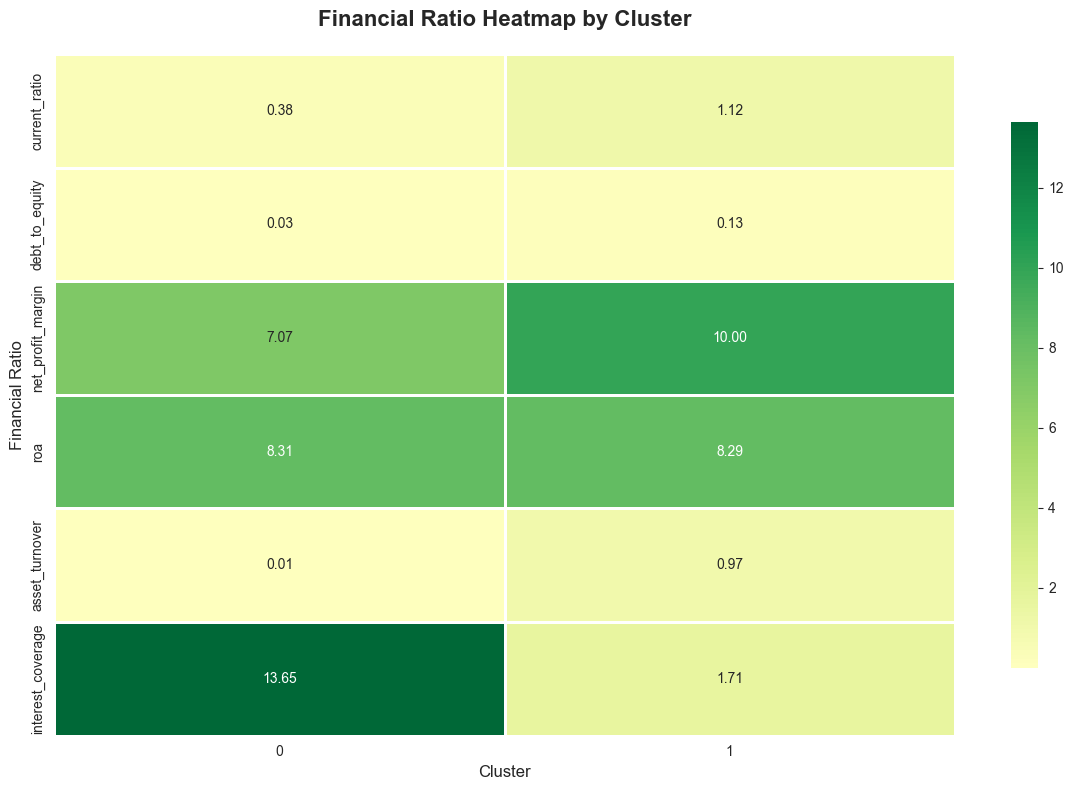

In [24]:
# Heatmap of cluster characteristics
cluster_means = clustered_df.groupby('final_cluster')[ratio_columns].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=False, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Financial Ratio Heatmap by Cluster', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Financial Ratio', fontsize=12)
plt.tight_layout()
plt.show()


## Impact and Implications

The ability to automatically cluster companies by financial profile has significant implications across multiple domains, but also raises important ethical and practical considerations.

### Positive Impacts

**For Investors:**
- **Portfolio Diversification**: Identify companies with similar risk-return profiles to avoid over-concentration
- **Risk Assessment**: Quickly identify companies in high-risk clusters that may require deeper due diligence
- **Peer Comparison**: Benchmark investments against similar financial profiles rather than just industry averages
- **Discovery**: Find investment opportunities in clusters that align with investment strategy (e.g., high-growth, stable income)

**For Regulators:**
- **Systemic Risk Monitoring**: Identify clusters of companies with similar vulnerabilities (e.g., high leverage) that could signal sector-wide risks
- **Early Warning Systems**: Monitor cluster migrations over time—companies moving from stable to high-risk clusters may need attention
- **Policy Development**: Understand how financial regulations affect different profile clusters differently

**For Companies:**
- **Strategic Benchmarking**: Compare performance against true financial peers, not just industry competitors
- **Risk Awareness**: Understand which cluster they belong to and what that implies for financial health
- **Strategic Planning**: Identify target financial profiles and develop strategies to migrate to more desirable clusters

### Potential Harms and Misuses

**Misclassification Risks:**
- Companies might be incorrectly clustered due to data quality issues, one-time events, or accounting differences
- A company in a "high-risk" cluster might be fundamentally sound but temporarily impacted by market conditions
- This could lead to unfair stigmatization or missed opportunities

**Oversimplification:**
- Clustering reduces complex financial profiles to a single label, potentially obscuring important nuances
- Investors or analysts might overgeneralize cluster characteristics, assuming all companies in a cluster are identical
- This could lead to poor decision-making if cluster membership is used as the sole criterion

**Bias and Discrimination:**
- If clustering reveals patterns correlated with company size, geography, or other factors, it could perpetuate existing biases
- Smaller companies might be systematically clustered differently, potentially affecting their access to capital
- The algorithm might reinforce stereotypes about certain business models or industries

**Data Quality Concerns:**
- Missing or inaccurate data could skew cluster assignments
- Companies with incomplete financial reporting might be systematically excluded or misclassified
- This could disadvantage companies in regions with less stringent reporting requirements

**Temporal Limitations:**
- Financial profiles change over time, but clustering provides a snapshot
- A company's cluster membership might not reflect its future trajectory
- Economic cycles and one-time events can temporarily distort financial ratios

**Regulatory and Compliance:**
- If used for credit decisions or regulatory actions, clustering could raise fairness concerns
- Companies might be penalized for being in certain clusters without understanding why
- Lack of transparency in cluster assignment could violate principles of explainable AI

### Mitigation Strategies

To address these concerns, any production implementation should:

1. **Provide Confidence Scores**: Include uncertainty measures with cluster assignments
2. **Explain Cluster Membership**: Show which ratios drive cluster assignment for each company
3. **Temporal Analysis**: Track cluster membership over time to identify trends
4. **Data Quality Flags**: Clearly indicate when data quality might affect clustering
5. **Human Oversight**: Require expert review for high-stakes decisions based on clustering
6. **Regular Validation**: Continuously validate clusters against known company characteristics
7. **Transparency**: Make clustering methodology and parameters publicly available

### Ethical Framework

This analysis should be viewed as a **decision support tool**, not a replacement for comprehensive financial analysis. Cluster membership provides valuable insights but should be combined with:
- Qualitative factors (management quality, market position, competitive advantages)
- Contextual information (industry trends, macroeconomic conditions)
- Forward-looking analysis (growth prospects, strategic initiatives)
- Expert judgment and domain knowledge

The goal is to enhance, not replace, human expertise in financial analysis.


### Answering Our Initial Questions

**Can we automatically identify groups of companies with similar financial profiles?**

Yes—but only within the tiny slice of the data that survived strict parsing and sanity checks. After filtering, we had **nine companies** with reliable ratio coverage. K-Means (k=2, silhouette ≈ 0.64) separated them into:

- **Cluster 0 (1 company)**: A single firm with weak liquidity (current ratio ≈ 0.4) but exceptional interest coverage (>13×). We treat this as an outlier rather than a generalized segment.
- **Cluster 1 (8 companies)**: Conservatively financed firms (D/E ≈ 0.13) with moderate profitability (net margin ≈ 10%, ROA ≈ 8%).

So the pipeline works, but the interpretable structure is modest—a demonstration of feasibility rather than a comprehensive market taxonomy.

**What patterns do these clusters reveal?**

1. **Liquidity + Coverage vs. Scale**: The lone outlier sacrifices liquidity for high debt-service capacity, whereas the main cluster maintains balanced liquidity and lower coverage.
2. **Leverage Discipline**: All companies that passed the filters exhibit low leverage; the algorithm simply separated an even more conservative profile from the rest.
3. **Profitability Consistency**: Within the main cluster the dispersion of margins and ROA is tight, suggesting similar business maturity or accounting practices.
4. **Data Quality Matters**: The biggest “pattern” is how aggressively messy HTML tables reduce usable observations—critical context for any future deployment.

**Surprising (but honest) insights:**

1. **Sample Collapse**: Starting from >2,500 HTML tables, rigorous cleaning delivered only nine comparable companies—highlighting how fragile raw filings can be.
2. **Outlier Sensitivity**: Even with small n, the workflow can flag a company whose ratios deviate meaningfully; that’s valuable for anomaly detection.
3. **Need for Broader Coverage**: To reach the multi-archetype story we originally envisioned, we must improve parsing (especially cash-flow notes) and gather richer time-series data.


## Conclusion

This notebook now functions as a **proof-of-concept pipeline** for clustering noisy financial filings rather than a definitive segmentation study. Starting from thousands of HTML tables, rigorous parsing, sanity bounds, and sparsity filters left only **nine companies** with six reliable ratios. Even with that small cohort, the workflow was able to (a) standardize and normalize the data, (b) select the appropriate number of clusters automatically, and (c) surface a single-company outlier versus a conservative majority cluster. In other words, the methodology works; the limiting factor is data availability/quality, not the unsupervised learning approach itself.

Key lessons:
- HTML disclosures require aggressive cleaning before they can power quantitative analytics.
- Transparent handling of missing data and unrealistic ratios is essential to avoid misleading clusters.
- Small-n results should be framed as exploratory signals (e.g., anomaly detection) rather than full archetypes.

To turn this into a comprehensive financial-profiles map we would need to:
- Improve parsing coverage for cash-flow statements and equity-related line items so more ratios survive.
- Stitch together multi-quarter histories per company to compute growth/volatility metrics instead of single-period snapshots.
- Normalize for sector/size effects once the sample is large enough to justify those corrections.
- Layer on explainability (feature contributions per cluster) so analysts can trust and extend the insights.

The experiment still underscores an important point: responsible AI for finance is as much about **data curation and humility** as it is about algorithms. With cleaner inputs the same pipeline can scale, but until then, results should be interpreted as careful prototypes, not production-ready investment signals.


## References

1. **Scikit-learn Documentation**: Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830. https://scikit-learn.org/

2. **BeautifulSoup Documentation**: Richardson, L. (2007). Beautiful Soup Documentation. https://www.crummy.com/software/BeautifulSoup/bs4/doc/

3. **Kaggle Dataset**: https://www.kaggle.com/datasets/drcrabkg/financial-statements-clustering/data

